# EVAC Examination

## Data Exploration

In [247]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from datetime import datetime
import math
from sklearn.metrics import r2_score


In [248]:
num_input_nodes = 9
num_hidden_nodes_1 = 16
num_hidden_nodes_2 = 16
num_output_nodes = 1

NUM_WEIGHTS = (num_input_nodes * num_hidden_nodes_1) + (num_hidden_nodes_1 * num_hidden_nodes_2) + (num_hidden_nodes_2 * num_output_nodes)
NUM_BIASES = num_hidden_nodes_1 + num_hidden_nodes_2 + num_output_nodes

IND_SIZE = NUM_WEIGHTS + NUM_BIASES

In [249]:
all_data = pd.read_csv('eScooterDemand.csv')
all_data.head()

,Date,Count,Hour,Temp,Humidity,Wind speed,Visibility,Dew point,Sunshine,Rain,Snow,Season,Public Holiday,HireAvailable
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No,Yes


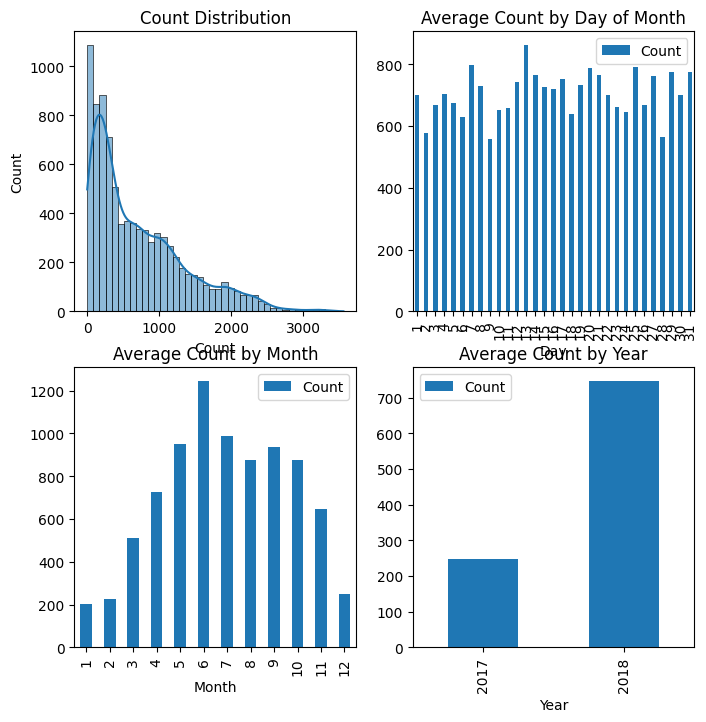

In [250]:


## plot average count over time to look for patterns that can be used to predict future demand
all_data['Date'] = pd.to_datetime(all_data['Date'], format='%d/%m/%Y')
all_data['Month'] = all_data['Date'].dt.month
all_data['Year'] = all_data['Date'].dt.year
all_data['Day'] = all_data['Date'].dt.day

## Show all plots on one figure
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
sns.histplot(all_data['Count'], kde=True, ax=ax[0, 0]).set_title('Count Distribution')
all_data.groupby('Day').aggregate({'Count': 'mean'}).plot(kind='bar', ax=ax[0, 1], title='Average Count by Day of Month')
all_data.groupby('Month').aggregate({'Count': 'mean'}).plot(kind='bar', ax=ax[1, 0], title='Average Count by Month')
all_data.groupby('Year').aggregate({'Count': 'mean'}).plot(kind='bar', ax=ax[1, 1], title='Average Count by Year')

plt.show()


## Set up representation

In [251]:
!pip install deap

In [252]:
from deap import base, creator, tools, algorithms, gp, creator
import random
import operator
from IPython import display


In [253]:
## Prepare data for training
all_data['Windspeed'] = all_data['Wind speed']
all_data['HireAvailable'] = all_data['HireAvailable'].map({'Yes': 1, 'No': 0})
all_data['PublicHoliday'] = all_data['Public Holiday'].map({'Yes': 1, 'No': 0})
## Create a new column for weekend and assign 1 if the day is a weekend and 0 if it is not from date
all_data['Weekend'] = all_data['Date'].dt.dayofweek.map(lambda x: 1 if x > 4 else 0)
all_data['Season'] = all_data['Season'].map({'Spring': 0, 'Summer': 1, 'Autumn': 2, 'Winter': 3})
all_data.head()

,Date,Count,Hour,Temp,Humidity,Wind speed,Visibility,Dew point,Sunshine,Rain,Snow,Season,Public Holiday,HireAvailable,Month,Year,Day,Windspeed,PublicHoliday,Weekend
0,2017-12-01,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,3,No,1,12,2017,1,2.2,0,0
1,2017-12-01,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,3,No,1,12,2017,1,0.8,0,0
2,2017-12-01,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,3,No,1,12,2017,1,1.0,0,0
3,2017-12-01,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,3,No,1,12,2017,1,0.9,0,0
4,2017-12-01,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,3,No,1,12,2017,1,2.3,0,0


In [254]:
all_data["Count"].describe()

count    8760.000000
mean      704.602055
std       644.997468
min         0.000000
25%       191.000000
50%       504.500000
75%      1065.250000
max      3556.000000
Name: Count, dtype: float64

In [255]:
## Data standardisation
from sklearn import preprocessing

features = [
 'Hour',
 'Temp',
 'Windspeed',
 'Visibility',
 'Dew point']
# for feature in features:
scaler = preprocessing.StandardScaler()
# Fit the scaler to your data
scaler.fit(all_data[features])

# Transform the selected features
all_data[features] = scaler.transform(all_data[features])



In [256]:
features

['Hour', 'Temp', 'Windspeed', 'Visibility', 'Dew point']

In [257]:
class MLP(object):
    def __init__(self, numInput, numHidden1, numHidden2, numOutput):
        self.fitness = 0
        self.numInput = numInput
        self.numHidden1 = numHidden1
        self.numHidden2 = numHidden2
        self.numOutput = numOutput

        self.w_i_h1 = np.random.randn(self.numHidden1, self.numInput)
        self.w_h1_h2 = np.random.randn(self.numHidden2, self.numHidden1)
        self.w_h2_o = np.random.randn(self.numOutput, self.numHidden2)

        self.b_i_h1 = [0] * numHidden1
        self.b_i_h2 = [0] * numHidden2
        self.b_i_output = [0] * numOutput

        self.ReLU = lambda x : max(0,x)

    def sigmoid(self,x):
        try:
            ans = (1 / (1 + math.exp(-x)))
        except OverflowError:
            ans = float('inf')
        return ans

    def softmax(self, x):
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum()

    def feed_forward(self, inputs):

        h1 = np.dot(self.w_i_h1, inputs)             # feed input to hidden layer 1
        h1 = [h + b for h, b in zip(h1, self.b_i_h1)]

        h1 = [self.ReLU(x) for x in h1]              # Activate hidden layer1

        h2 = np.dot(self.w_h1_h2, h1)                # feed layer 1 to hidden layer 2
        h2 = [h + b for h, b in zip(h2, self.b_i_h2)]
        h2 = [self.ReLU(x) for x in h2]              # Activate hidden layer 2

        output = np.dot(self.w_h2_o, h2)             # feed to output layer
        output = [o + b for o, b in zip(output, self.b_i_output)]
        return output

    # Weights get set as:
    # Weights to layer h1, h2, o
    # Biases to layer h1, h2, o
    def set_weights_linear(self, Wgenome):
        numWeights_I_H1 = self.numHidden1 * self.numInput
        numWeights_H1_H2 = self.numHidden2 * self.numHidden1
        numWeights_H2_O = self.numOutput * self.numHidden2

        # Weights (multi-dimensional arrays)

        first_slice_end = numWeights_I_H1

        self.w_i_h1 = np.array(Wgenome[:first_slice_end])
        self.w_i_h1 = self.w_i_h1.reshape((self.numHidden1, self.numInput))

        second_slice_end = first_slice_end + numWeights_H1_H2

        self.w_h1_h2 = np.array(Wgenome[first_slice_end:second_slice_end])
        self.w_h1_h2 = self.w_h1_h2.reshape((self.numHidden2, self.numHidden1))

        third_slice_end = second_slice_end + numWeights_H2_O

        self.w_h2_o = np.array(Wgenome[second_slice_end:third_slice_end])
        self.w_h2_o = self.w_h2_o.reshape((self.numOutput, self.numHidden2))

        # Biases (flat arrays for each layer)

        fourth_slice_end = third_slice_end + self.numHidden1

        self.b_i_h1 = np.array(Wgenome[third_slice_end:fourth_slice_end])

        fith_slice_end = fourth_slice_end + self.numHidden2

        self.b_i_h2 = np.array(Wgenome[fourth_slice_end:fith_slice_end])

        self.b_i_output = np.array(Wgenome[fith_slice_end:])

    def get_weights(self):
        return np.concatenate((self.w_i_h1.flatten(), self.w_h1_h2.flatten(), self.w_h2_o.flatten(), self.b_i_h1, self.b_i_h2, self.b_i_output))

In [258]:
creator.create("FitnessMax", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, -1.0, 1.0)
toolbox.register("individual", tools.initRepeat, creator.Individual,
                 toolbox.attr_float, n=IND_SIZE)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [259]:
import numpy
# randomise data
all_data = all_data.sample(frac=1).reset_index(drop=True)
test_data = all_data.sample(frac=0.2)
train_data = all_data.drop(test_data.index)
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)
print(all_data.size)
print(test_data.size)

print(train_data.size)
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", numpy.mean)
mstats.register("std", numpy.std)
mstats.register("min", numpy.min)
mstats.register("max", numpy.max)


175200
35040
140160


In [260]:

## Mean absolute error: On some regression problems, the distribution of the target variable may be mostly Gaussian, but may have outliers, e.g. large or small values far from the mean value.

def eval(individual, myNet, evdata):
  myNet.set_weights_linear(individual)
  fitness = 0
  preds = []
  for i in range(len(evdata)):
    input = [evdata['PublicHoliday'][i], evdata['Weekend'][i], evdata['Month'][i], evdata['Hour'][i], evdata['Temp'][i], evdata['Windspeed'][i], evdata['Visibility'][i], evdata["HireAvailable"][i], evdata['Dew point'][i]]
    output = myNet.feed_forward(input)
    preds.append(output)
    fitness += (evdata['Count'][i] - output[0])**2

  return fitness/len(evdata),





In [261]:
toolbox.register("evaluate", eval)

toolbox.register("select", tools.selTournament, tournsize=3)

toolbox.register("mutate", tools.mutGaussian, mu=0.0, sigma=0.5, indpb=0.5)

toolbox.register("population", tools.initRepeat, list, toolbox.individual)


myNet = MLP(num_input_nodes, num_hidden_nodes_1, num_hidden_nodes_2, num_output_nodes)

baseline = toolbox.evaluate(myNet.get_weights(), myNet, train_data)
print(baseline)

(946488.2127769269,)


In [262]:
stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

In [263]:
## SANITYY CHECK
ind = toolbox.individual()
print(ind)
print(ind.fitness.values)
print(len(ind.fitness.weights))
print(len(toolbox.evaluate(ind, myNet, train_data)))
print(ind.fitness.weights)
ind.fitness.values = toolbox.evaluate(ind, myNet, train_data)

print(ind.fitness.valid)
# print(myNet.feedForward([-10, 4, 3, 2, 1, 5, 5]))
print(toolbox.evaluate(ind, myNet, train_data))

[0.7877880908780193, -0.5927086467453078, 0.9202470617105869, 0.6736661828755646, -0.5396517463786865, 0.010701222832521173, -0.3579477945383325, 0.189040438785266, 0.9990076438396533, -0.04703020568738281, -0.45494732250176617, -0.8790304570573626, 0.9624807704165739, -0.04636524572668832, 0.3287706641384518, 0.42347248123004055, 0.09117292078846795, -0.32478783441206227, -0.8545432675296487, 0.7100105893961435, 0.23384168179707054, -0.3232965380260846, 0.040954310775910496, -0.3426564246937511, 0.4571853674422517, -0.28031411279968466, -0.24352681367237294, 0.18333735855213473, -0.8111024801635438, 0.194760032227435, 0.9553051267980575, 0.46776482008807996, -0.8624406392726403, -0.025487311404232438, -0.3863684401752767, -0.18548390324016406, -0.18704583420329346, 0.06826017429895437, -0.6932939344584683, -0.6782691699875834, 0.9897711300034264, -0.13890405575619846, -0.9027641097520414, 0.032830996455354144, -0.6786869176943373, -0.9317977702681188, 0.7725916078192212, -0.1149815413

In [264]:
logbook = tools.Logbook()
hof = tools.HallOfFame(1)
pop = toolbox.population(n=100)

In [265]:
fitnesses = [toolbox.evaluate(indiv, myNet, train_data) for indiv in pop]
for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit

In [266]:
NGEN = 200

for g in range(NGEN):
    print("-- Generation %i --" % g)
      
    offspring = toolbox.select(pop, len(pop))
    offspring = list(map(toolbox.clone, offspring))

    for mutant in offspring:
        toolbox.mutate(mutant)
        del mutant.fitness.values
                         
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = [toolbox.evaluate(indiv, myNet, train_data) for indiv in invalid_ind]
    for ind, fit in zip(invalid_ind, fitnesses):
         ind.fitness.values = fit
    
    pop[:] = offspring
    record = stats.compile(pop)
    logbook.record(gen=g, **record)

    gen = [g] * 100
    hof.update(pop)
    if g%5==0:
      print(record)



-- Generation 0 --
{'avg': 895528.1890196918, 'std': 22239.295401896205, 'min': 832419.0125368232, 'max': 964471.777447694}
-- Generation 1 --
-- Generation 2 --
-- Generation 3 --
-- Generation 4 --
-- Generation 5 --
{'avg': 707612.0474472134, 'std': 69583.17793222526, 'min': 504737.7044256867, 'max': 862791.9938223477}
-- Generation 6 --
-- Generation 7 --
-- Generation 8 --
-- Generation 9 --
-- Generation 10 --
{'avg': 480758.69184379437, 'std': 32849.32373725986, 'min': 420945.2922454816, 'max': 602426.718704437}
-- Generation 11 --
-- Generation 12 --
-- Generation 13 --
-- Generation 14 --
-- Generation 15 --
{'avg': 420885.251406894, 'std': 38898.211141276945, 'min': 363331.5369393854, 'max': 653188.2729550649}
-- Generation 16 --
-- Generation 17 --
-- Generation 18 --
-- Generation 19 --
-- Generation 20 --
{'avg': 387786.59223889036, 'std': 43492.87295901218, 'min': 314746.84494187334, 'max': 577998.9927725408}
-- Generation 21 --
-- Generation 22 --
-- Generation 23 --
-- 

In [267]:
print(logbook)
print([i[:1] for i in hof.items[:10]])



avg   	gen	max        	min   	std    
895528	0  	964472     	832419	22239.3
875866	1  	945027     	801890	29914  
844938	2  	948494     	711289	42930.7
807420	3  	972838     	627147	60223.8
758072	4  	893855     	539910	64705.7
707612	5  	862792     	504738	69583.2
648289	6  	870049     	470610	82172.6
580153	7  	822265     	473463	70067.8
535180	8  	718760     	449556	53510.9
502829	9  	691340     	439271	41468.3
480759	10 	602427     	420945	32849.3
468495	11 	653958     	402746	35983.2
455154	12 	587537     	391662	34820.1
448093	13 	661940     	370904	40869.2
429072	14 	516373     	364537	32763.6
420885	15 	653188     	363332	38898.2
412746	16 	629226     	351355	36573.4
421973	17 	911113     	341115	64265.4
415404	18 	641495     	350876	49853.3
398678	19 	604359     	317873	45656.6
387787	20 	577999     	314747	43492.9
382589	21 	661232     	315524	46868  
384981	22 	568188     	312627	45189.4
376385	23 	519629     	314293	42908.9
368834	24 	496071     	295723	40656.2
372890	25 	5

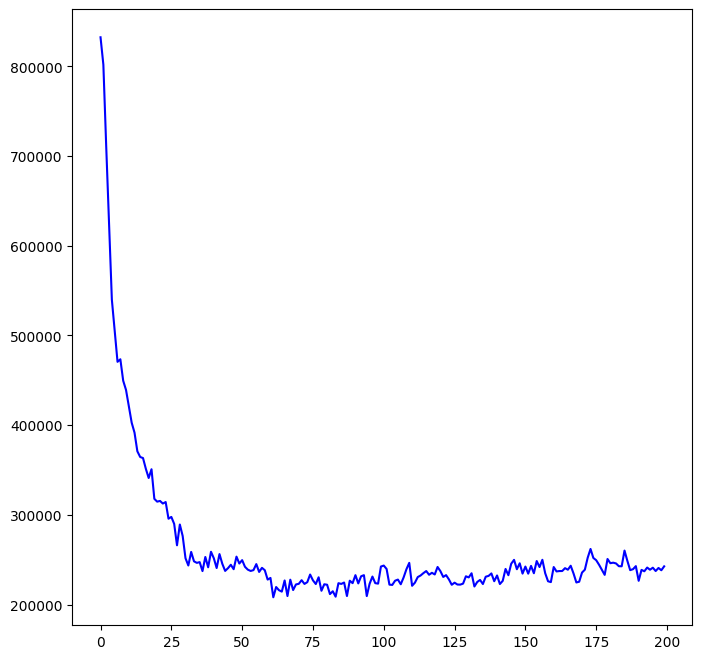

In [268]:
## graph of the min fitness value over generations
gen = logbook.select("gen")
fit_mins = logbook.select("min")
fit_maxs = logbook.select("max")
fit_avgs = logbook.select("avg")

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(gen, fit_mins, "b", label="Minimum")


[-3.8768407838780483, -4.314122940653858, 2.666255409666103, -0.44973259823443656, -2.642322180403875, 1.929069481474531, 5.36958294205507, 6.39978909294853, 1.9724848543737488, -4.240970776798896, -3.925615387722358, -2.3780484972863367, -3.4307679569067644, -3.720125563167021, -0.7722502456880435, 0.10284109499429225, -3.392359903587051, 0.5180713260834269, 2.1453463551444334, 1.7464328311839221, 2.092020092287928, -4.6298345419775, 1.2013887337939817, 2.1354424732109876, 0.33914851397103507, -0.19179735772815165, -0.2802178457234321, -0.5962308988351281, 0.8663721696957493, 1.0620096840837627, 3.3064162717030934, -9.478145323960753, 3.8053211907992917, -0.287452137971244, -1.3869765266244356, -0.11039640226864708, -0.24654270928940608, -1.8799175286367462, 2.4403893913575687, 4.726791596385594, -0.503058111451984, 0.5138376661703169, 2.392611080961111, 5.643532511838587, 0.5905763757756698, -0.19979220073002416, -1.860413357237653, 4.968612070037963, -1.2717085834398194, 1.039806608

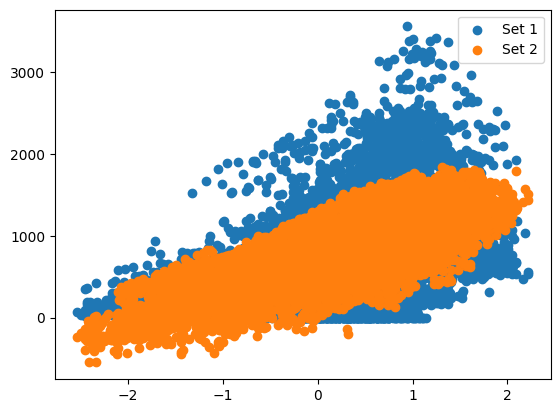

In [269]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

best_ind = hof[0]

print(best_ind)
print(toolbox.evaluate(best_ind, myNet, train_data))
myNet.set_weights_linear(best_ind)
inputs = [[train_data['PublicHoliday'][i], train_data['Weekend'][i], train_data['Month'][i], train_data['Hour'][i], train_data['Temp'][i], train_data['Windspeed'][i], train_data['Visibility'][i], train_data["HireAvailable"][i], train_data['Dew point'][i]] for i in range(len(train_data))]

x_values1 = train_data['Temp'].to_list()
y_values1 = train_data['Count'].to_list()

x_values2 = train_data['Temp'].to_list()
y_values2 = [myNet.feed_forward(i) for i in inputs] 

R2 = r2_score(y_values1, y_values2)
print(R2)
print(y_values2)
plt.scatter(x_values1, y_values1, label='Set 1')
plt.scatter(x_values2, y_values2, label='Set 2')

# Add a legend to explain which line is which
plt.legend()

# Display the plot
plt.show()

In [270]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

best_ind = hof[0]

print(best_ind)
print(toolbox.evaluate(best_ind, myNet, train_data))
myNet.set_weights_linear(best_ind)
inputs = [[test_data['PublicHoliday'][i], test_data['Weekend'][i], test_data['Month'][i], test_data['Hour'][i], test_data['Temp'][i], test_data['Windspeed'][i], test_data['Visibility'][i], test_data["HireAvailable"][i]] for i in range(len(test_data))]

x_values1 = test_data['Dew point'].to_list()
y_values1 = test_data['Count'].to_list()

x_values2 = test_data['Dew point'].to_list()
y_values2 = [myNet.feed_forward(i) for i in inputs] 

R2 = r2_score(y_values1, y_values2)
print(R2)
print(y_values2)
plt.scatter(x_values1, y_values1, label='Set 1')
plt.scatter(x_values2, y_values2, label='Set 2')

# Add a legend to explain which line is which
plt.legend()

# Display the plot
plt.show()

[-3.8768407838780483, -4.314122940653858, 2.666255409666103, -0.44973259823443656, -2.642322180403875, 1.929069481474531, 5.36958294205507, 6.39978909294853, 1.9724848543737488, -4.240970776798896, -3.925615387722358, -2.3780484972863367, -3.4307679569067644, -3.720125563167021, -0.7722502456880435, 0.10284109499429225, -3.392359903587051, 0.5180713260834269, 2.1453463551444334, 1.7464328311839221, 2.092020092287928, -4.6298345419775, 1.2013887337939817, 2.1354424732109876, 0.33914851397103507, -0.19179735772815165, -0.2802178457234321, -0.5962308988351281, 0.8663721696957493, 1.0620096840837627, 3.3064162717030934, -9.478145323960753, 3.8053211907992917, -0.287452137971244, -1.3869765266244356, -0.11039640226864708, -0.24654270928940608, -1.8799175286367462, 2.4403893913575687, 4.726791596385594, -0.503058111451984, 0.5138376661703169, 2.392611080961111, 5.643532511838587, 0.5905763757756698, -0.19979220073002416, -1.860413357237653, 4.968612070037963, -1.2717085834398194, 1.039806608

ValueError: shapes (16,9) and (8,) not aligned: 9 (dim 1) != 8 (dim 0)

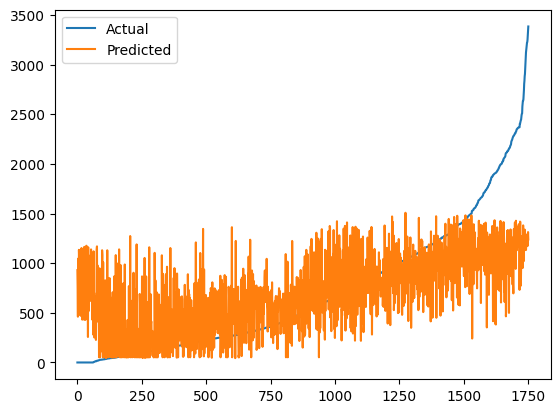

In [ ]:
best_ind = hof.items[0]

test_data.sort_values(by=['Count'], inplace=True)
test_data = test_data.reset_index(drop=True)
inputs = [[test_data['PublicHoliday'][i], test_data['Weekend'][i], test_data['Month'][i], test_data['Hour'][i], test_data['Temp'][i], test_data['Windspeed'][i], test_data['Visibility'][i], test_data["HireAvailable"][i], train_data["Dew point"][i]] for i in range(len(test_data))]
x = [i for i in range(len(test_data))]
y_values1 = test_data['Count'].to_list()
y_values2 = [myNet.feed_forward(i) for i in inputs]
plt.plot(x, y_values1, label='Actual')
plt.plot(x, y_values2, label='Predicted')
plt.legend()
plt.show()

[-1.8064883428754341, -3.9265798333225437, -1.8823799855649215, -5.324537465785179, -1.7201359509124856, 7.302084807465165, -3.7230534349906415, -3.5801173308020102, 4.870073932241842, -0.9516875147305217, 1.9816617807720671, 1.66203930660329, -0.3301188786043178, -0.14642904860904965, 1.0708451022939893, 0.3452874274444697, 1.999845506056788, 3.2124533287167134, 4.648747305907465, 2.116093918405072, -3.0411621134126587, 4.073316475697847, -1.9619744061329927, 1.847721806449336, -2.877293460492272, -4.351436772850911, -9.03998903745597, -2.1333004049034234, 1.6153046017529942, -0.3767565897899512, 1.2470743576161512, 2.194376134140887, -2.0296145962891563, -0.638981923238878, -5.0597924379889765, -3.970530391424252, -2.5255392995668613, 0.8789734190290797, -6.667058306748179, -3.710666325981543, 5.295944346218073, -5.154294252915754, -7.869326282908662, -1.4373101345675157, 3.9379895476099263, -7.444415933524057, -2.9449516469022115, -11.736318463828713, -2.7259009383993824, 4.22675298

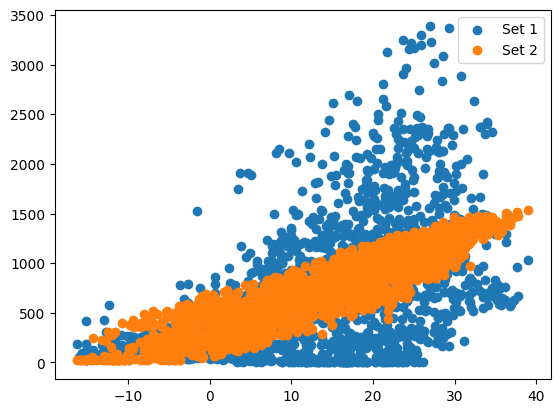

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

best_ind = hof.items[0]

print(best_ind)
print(toolbox.evaluate(best_ind, myNet, train_data))
print(toolbox.evaluate(best_ind, myNet, test_data))
myNet.set_weights_linear(best_ind)
inputs = [[test_data['Season'][i], test_data['PublicHoliday'][i], test_data['Weekend'][i], test_data['Month'][i], test_data['Hour'][i], test_data['Temp'][i], test_data['Windspeed'][i], test_data['Visibility'][i], test_data["HireAvailable"][i]] for i in range(len(test_data))]

x_values1 = test_data['Temp'].to_list()
y_values1 = test_data['Count'].to_list()

x_values2 = test_data['Temp'].to_list()
y_values2 = [myNet.feed_forward(i) for i in inputs] 

R2 = r2_score(y_values1, y_values2)
print(R2)
print(y_values2)
plt.scatter(x_values1, y_values1, label='Set 1')
plt.scatter(x_values2, y_values2, label='Set 2')

# Add a legend to explain which line is which
plt.legend()

# Display the plot
plt.show()

[[708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337

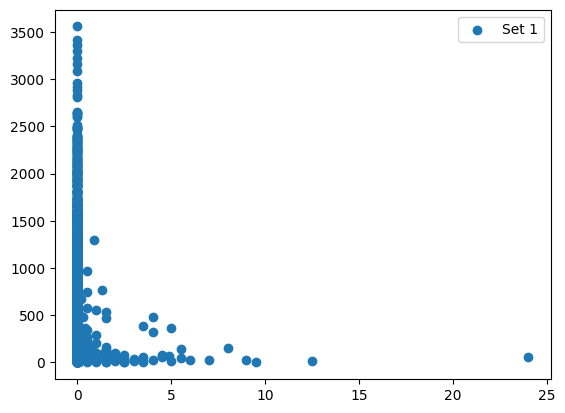

[29.096660147330937, 12.581272755715162, -0.38149388340117474, 4.957464629270712, 17.309974820025115, 11.415954409279552, -11.676366097190355, 0.046927422359391735, 9.779333286707804, 29.47839321443361, -5.395387520191839, 9.337687348597694, 14.92676670717382, -11.369634820100051, 26.64884397584116, 5.903664444034511, 15.717840450901218, 5.509973022960861, -24.074342490914763, 12.147669431831458, -5.429587036006186, 10.482114204623247, -11.919175301840948, 10.506377839387271, 1.6407556159264127, -11.942255391677476, 2.046754985028316, -4.5900594614014665, 17.106176546169976, -14.542911608606264, 4.4709820457791505, 1.5143974938124862, 12.675046211125776, 14.02482130623536, -8.205001241605178, 10.284344532687994, 9.542702385525882, 27.737329178993306, -7.330473267391048, 0.032744458846772684, -18.402472558215923, -7.099667658461653, 17.608404934296434, -4.666802491783139, -10.08339554606045, 7.750222360437842, 3.19722542153973, -5.676025704269632, -6.013707791185976, 10.8650930785805, -

In [ ]:
# Assuming you have two sets of data:
x_values1 = test_data['Rain'].to_list()
y_values1 = test_data['Count'].to_list()

# x_values2 = test_data['Rain'].to_list()
# y_values2 = [myNet.feedForward(i) for i in inputs] 

print(y_values2)
plt.scatter(x_values1, y_values1, label='Set 1')
# plt.scatter(x_values2, y_values2, label='Set 2')

# Add a legend to explain which line is which
plt.legend()

# Display the plot
plt.show()
print(best_ind)

In [ ]:
# Assuming you have two sets of data:
x_values1 = evdata['Month'].to_list()
y_values1 = evdata['Count'].to_list()

x_values2 = evdata['Month'].to_list()
y_values2 = [myNet.feedForward(i) for i in inputs] 

print(y_values2)
plt.scatter(x_values1, y_values1, label='Set 1')
plt.scatter(x_values2, y_values2, label='Set 2')

# Add a legend to explain which line is which
plt.legend()

# Display the plot
plt.show()

NameError: name 'evdata' is not defined

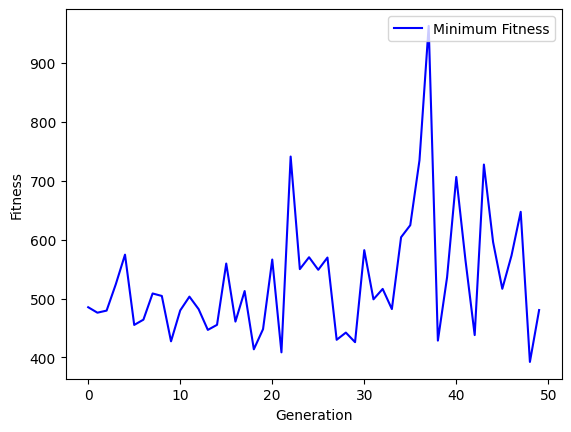

In [ ]:
## Graph fitness over generations

gen = logbook.select("gen")
fit_mins = logbook.select("min")


plt.plot(gen, fit_mins, "b-", label="Minimum Fitness")

plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend(loc="upper right")

plt.show()